# Reproduction of FSL's course example on fluency_task dataset using FEAT

The pipelines were adapted on a dataset downloadable [**here**](https://fsl.fmrib.ox.ac.uk/fslcourse/#Data). 
These data & script reproduce the [**Section 3 practical session**](https://fsl.fmrib.ox.ac.uk/fslcourse/lectures/practicals/feat1/index.html) of the FSL course.

To use the notebooks, create a docker container using the instructions in the file and use the parent repository of **"analytic_variability_fmri"** as a volume. The dataset should be downloaded in a repository named **"fluency_task"** in the directory **"data"** inside this repository. 
Otherwise, if you want to use different paths, you need to update these paths on the notebooks. 

This notebook is separated into **2 parts** : 
* Preprocessing
* 1st level analysis 

The first part can be run by its own but the 1st level analysis require that the preprocessing was already run. 

In [1]:
# Set the path to matlab 
## NECESSARY TO USE SPM
from nipype.interfaces import spm
matlab_cmd = '/opt/spm12-r7771/run_spm12.sh /opt/matlabmcr-2010a/v713/ script'
spm.SPMCommand.set_mlab_paths(matlab_cmd=matlab_cmd, use_mcr=True)

In [2]:
from nipype.interfaces.spm import (RealignUnwarp, SliceTiming, Smooth, Coregister, NewSegment, Normalize12,
                                    Level1Design, EstimateModel, EstimateContrast, Threshold)
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.algorithms.misc import Gunzip
from nipype.interfaces.base import Bunch 
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node

from nilearn import plotting
%matplotlib inline
from os.path import join as opj
import os

In [3]:
# REPOSITORIES TO STORE FILES 
exp_dir = '/home/analytic_variability_fmri/data/fluency_task'
working_dir = 'workingdir_spm'
output_dir = 'datasink_spm'

In [4]:
# BASIC VARIABLES
N = 42

TR = 4.2

TA = TR - TR/N

fwhm = 7

contrasts = [('Generation', 'T', ['Generation', 'Shadowing'], [1, 0]),
            ('Shadowing', 'T', ['Generation', 'Shadowing'], [0, 1]),
            ('Mean', 'T', ['Generation', 'Shadowing'], [1, 1]),
            ('Shadowing > Generation', 'T', ['Generation', 'Shadowing'], [-1, 1]),
            ('Generation > Shadowing', 'T', ['Generation', 'Shadowing'], [1, -1])]

In [5]:
# NODE AND TEMPLATE FOR SELECTING FILES 
func_file = 'fmri.nii.gz'

anat_file = 'structural.nii.gz'

templates = {'anat' : anat_file, 'func' : func_file}

selectfiles = Node(SelectFiles(templates, base_directory = exp_dir), 
                   name = 'selectfiles')

gunzip_func = Node(Gunzip(), name = 'gunzip_func')

gunzip_anat = Node(Gunzip(), name = 'gunzip_anat')

In [6]:
# NODE FOR OUTPUT FILES (store the wanted results in the wanted repository)
datasink = Node(DataSink(base_directory=exp_dir, container=output_dir), name='datasink')

In [7]:
def get_vox_dims(volume):
    ''' 
    Function that gives the voxel dimension of an image. 
    Not used here but if we use it, modify the connection to : 
    (slice_timing, normalize_func, [('timecorrected_files', 'apply_to_files'),
                                    (('timecorrected_files', get_vox_dims),
                                     'write_voxel_sizes')])
    '''
    import nibabel as nb
    if isinstance(volume, list):
        volume = volume[0]
    nii = nb.load(volume)
    hdr = nii.header
    voxdims = hdr.get_zooms()
    return [float(voxdims[0]), float(voxdims[1]), float(voxdims[2])]

In [8]:
# NODES FOR THE MAIN WORKFLOW 
## Realignment
realign = Node(RealignUnwarp(), name='realign')

## Slice timing
slice_timing = Node(SliceTiming(num_slices = N, time_repetition = TR, time_acquisition = TA, 
                                slice_order = [i for i in range(N, 0, -1)], ref_slice = N/2), 
                    name = 'slice_timing')

## Normalization
norm_anat = Node(Normalize12(jobtype = 'write'), name = 'norm_anat')

norm_func = Node(Normalize12(jobtype = 'write'), name = 'norm_func')

## Smoothing
smooth = Node(Smooth(fwhm = fwhm), name = 'smooth')

In [9]:
# COREGISTRATION + SEGMENT WORKFLOW TO RUN IN PARALLEL
## Coregistration 
coreg = Node(Coregister(), name = 'coreg')

## Segmentation 
seg = Node(NewSegment(write_deformation_fields = [False, True], 
                      channel_info = (0.0001, 60, (True, True))), name = 'seg')

In [10]:
## Definition of the WorkFlow
coregwf = Workflow(name = 'coregwf')
coregwf.base_dir = opj(exp_dir, working_dir)

## Connection of nodes inside the workflow 
coregwf.connect([(coreg, seg, [('coregistered_source', 'channel_files')])])

In [11]:
# DEFINITION OF THE MAIN WORKFLOW
preprocess = Workflow(name='preprocess')
preprocess.base_dir = opj(exp_dir, working_dir)

# CONNECTION OF NODES INSIDE THE WORKFLOW
preprocess.connect([(selectfiles, gunzip_func, [('func', 'in_file')]),
                    (selectfiles, gunzip_anat, [('anat', 'in_file')]),
                    (gunzip_func, realign, [('out_file', 'in_files')]),
                   (realign, slice_timing, [('realigned_unwarped_files', 'in_files')]),
                   (realign, coregwf, [('mean_image', 'coreg.target')]),
                   (gunzip_anat, coregwf, [('out_file', 'coreg.source')]),
                   (coregwf, norm_func, [('seg.forward_deformation_field', 'deformation_file')]),
                   (slice_timing, norm_func, [('timecorrected_files', 'apply_to_files'),
                                    (('timecorrected_files', get_vox_dims),
                                     'write_voxel_sizes')]),
                   (coregwf, norm_anat, [('seg.forward_deformation_field', 'deformation_file'), 
                                        ('seg.bias_corrected_images', 'apply_to_files')]),
                    (norm_func, smooth, [('normalized_files', 'in_files')]),
                    (realign, datasink, [('realignment_parameters', 'preprocess.@par')]),
                    (coregwf, datasink, [('seg.transformation_mat', 'preprocess.@mat_file')]),
                    (norm_anat, datasink, [('normalized_files', 'preprocess@anat_norm')]),
                    (smooth, datasink, [('smoothed_files', 'preprocess.smoothed_files')])
                   ])

210221-11:24:00,145 nipype.workflow INFO:
	 Generated workflow graph: /home/analytic_variability_fmri/data/fluency_task/workingdir_spm/preprocess/graph.png (graph2use=colored, simple_form=True).


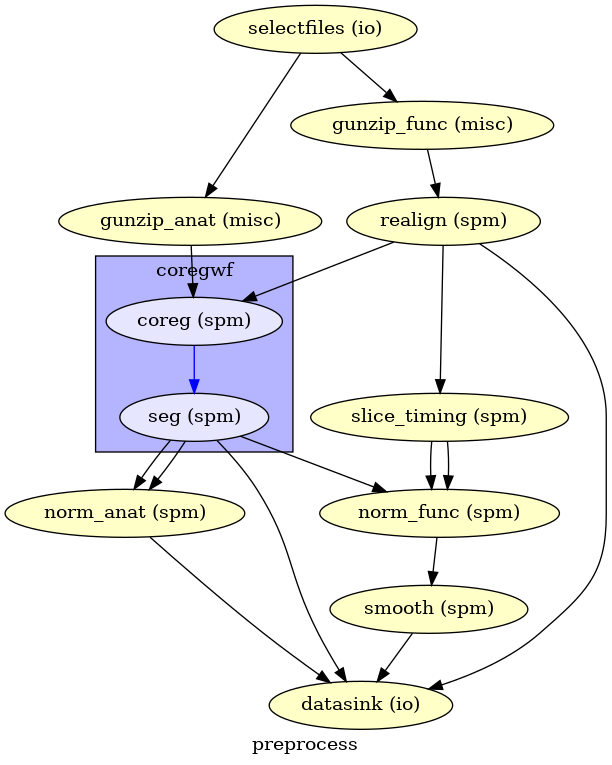

In [12]:
# Create preprocESS output graph
preprocess.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preprocess.base_dir, 'preprocess', 'graph.png'))

In [13]:
preprocess.run()

210221-11:24:02,813 nipype.workflow INFO:
	 Workflow preprocess settings: ['check', 'execution', 'logging', 'monitoring']
210221-11:24:02,825 nipype.workflow INFO:
	 Running serially.
210221-11:24:02,826 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.selectfiles" in "/home/analytic_variability_fmri/data/fluency_task/workingdir_spm/preprocess/selectfiles".
210221-11:24:02,829 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
210221-11:24:02,834 nipype.workflow INFO:
	 [Node] Finished "preprocess.selectfiles".
210221-11:24:02,835 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.gunzip_anat" in "/home/analytic_variability_fmri/data/fluency_task/workingdir_spm/preprocess/gunzip_anat".
210221-11:24:02,838 nipype.workflow INFO:
	 [Node] Running "gunzip_anat" ("nipype.algorithms.misc.Gunzip")
210221-11:24:03,23 nipype.workflow INFO:
	 [Node] Finished "preprocess.gunzip_anat".
210221-11:24:03,23 nipype.workflow INFO:
	 [Node] Setting-up "prep

In [14]:
templates = {'smooth' : opj(output_dir, 'preprocess', 'smoothed_files', 
                            'swaufmri.nii'),
            'param' : opj(output_dir, 'preprocess',
                         'rp_fmri.txt')}

selectfiles_analysis = Node(SelectFiles(templates, base_directory = exp_dir), name = 'selectfiles_analysis')

In [15]:
datasink_analysis = Node(DataSink(base_directory = exp_dir, container=output_dir), name = 'datasink_analysis')

In [16]:
import pandas as pd

word_gen = pd.read_table('/home/analytic_variability_fmri/data/fluency_task/word_generation.txt', header=None, 
                         names = ['onset', 'duration', 'amplitude'], index_col=False)

word_shad = pd.read_table('/home/analytic_variability_fmri/data/fluency_task/word_shadowing.txt', header=None, 
                         names = ['onset', 'duration', 'amplitude'], index_col=False)

conditions = ['Generation', "Shadowing"]
word_generation_onsets = word_gen.onset.tolist()
word_generation_durations = word_gen.duration.tolist()
word_shadowing_onsets = word_shad.onset.tolist()
word_shadowing_durations = word_shad.duration.tolist()

subject_info = [Bunch(conditions = conditions, durations = [word_generation_durations, word_shadowing_durations], 
                     onsets = [word_generation_onsets, word_shadowing_onsets])]

In [22]:
specify_model = Node(SpecifySPMModel(high_pass_filter_cutoff = 100,
                                 input_units = 'secs', 
                                 output_units = 'secs',
                                 subject_info = subject_info,
                                 time_repetition = TR), name = 'specify_model')

## Design level 1
l1design = Node(Level1Design(bases = {'hrf' : {'derivs' : [0,0]}}, interscan_interval = TR, 
                            timing_units = 'secs'), name = 'l1design')
## Estimate model
l1estimate = Node(EstimateModel(estimation_method = {'Classical' : 1}), name = 'l1estimate')

## Estimate contrast
contrast_estimate = Node(EstimateContrast(contrasts = contrasts), name = 'contrast_estimate')

## Thresholded maps
threshold = Node(Threshold(contrast_index = 1), name = 'threshold')

In [23]:
analysis = Workflow(name = 'analysis')
analysis.base_dir = opj(exp_dir, working_dir)

analysis.connect([(specify_model, l1design, [('session_info', 'session_info')]),
                            (selectfiles_analysis, specify_model, [('smooth', 'functional_runs'),
                                ('param', 'realignment_parameters')]),
                            (l1design, l1estimate, [('spm_mat_file', 'spm_mat_file')]),
                            (l1estimate, contrast_estimate, [('spm_mat_file', 'spm_mat_file'),
                                ('beta_images', 'beta_images'),
                                ('residual_image', 'residual_image')]),
                            (contrast_estimate, datasink_analysis, [('con_images', 'analysis.@con_images'),
                                ('spmT_images', 'analysis.@spmT_images'),
                                ('spm_mat_file', 'analysis.@spm_mat_file')])
                           ])

210221-11:27:38,440 nipype.workflow INFO:
	 Generated workflow graph: /home/analytic_variability_fmri/data/fluency_task/workingdir_spm/analysis/graph.png (graph2use=colored, simple_form=True).


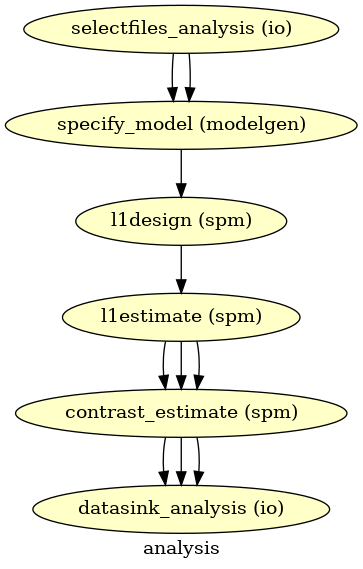

In [24]:
# Create analysis_non_param output graph
analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(analysis.base_dir, 'analysis', 'graph.png'))

In [25]:
analysis.run()

210221-11:27:39,171 nipype.workflow INFO:
	 Workflow analysis settings: ['check', 'execution', 'logging', 'monitoring']
210221-11:27:39,179 nipype.workflow INFO:
	 Running serially.
210221-11:27:39,181 nipype.workflow INFO:
	 [Node] Setting-up "analysis.selectfiles_analysis" in "/home/analytic_variability_fmri/data/fluency_task/workingdir_spm/analysis/selectfiles_analysis".
210221-11:27:39,183 nipype.workflow INFO:
	 [Node] Running "selectfiles_analysis" ("nipype.interfaces.io.SelectFiles")
210221-11:27:39,187 nipype.workflow INFO:
	 [Node] Finished "analysis.selectfiles_analysis".
210221-11:27:39,188 nipype.workflow INFO:
	 [Node] Setting-up "analysis.specify_model" in "/home/analytic_variability_fmri/data/fluency_task/workingdir_spm/analysis/specify_model".
210221-11:27:39,195 nipype.workflow INFO:
	 [Node] Running "specify_model" ("nipype.algorithms.modelgen.SpecifySPMModel")
210221-11:27:39,207 nipype.workflow INFO:
	 [Node] Finished "analysis.specify_model".
210221-11:27:39,208 ni